In [1]:
import gym
gym.logger.set_level(40)

import random
import torch
import numpy as np
from collections import deque

from IPython import display
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline

from ddpg_agent import *

In [5]:
env = gym.make('BipedalWalker-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State shape: ', state_size)
print('Action shape: ', action_size)

# each action dim value ranges from -1 to 1, so add tanh as to the actor network
print(env.action_space.high,env.action_space.low)
# action scale and state scale are different, so apply a separate layer before concat
print(env.observation_space.high,env.observation_space.low)

State shape:  24
Action shape:  4
[1. 1. 1. 1.] [-1. -1. -1. -1.]
[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf] [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]


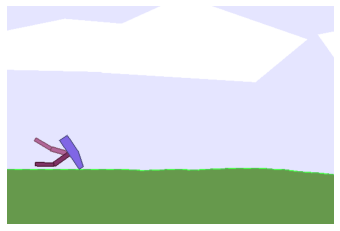

In [4]:
buffer = ReplayBuffer(300)
img = plt.imshow(env.render(mode='rgb_array'))
state = env.reset()
for j in range(200):
    action = env.action_space.sample() 
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    buffer.add(state, action, reward, next_state, done)
    if done:
        break 
    state = next_state
env.close()

(array([29., 15., 27., 30., 33., 25., 24., 35., 19., 19.]),
 array([-2.9633883e-03, -2.3705349e-03, -1.7776814e-03, -1.1848280e-03,
        -5.9197453e-04,  8.7893568e-07,  5.9373240e-04,  1.1865859e-03,
         1.7794393e-03,  2.3722928e-03,  2.9651462e-03], dtype=float32),
 <a list of 10 Patch objects>)

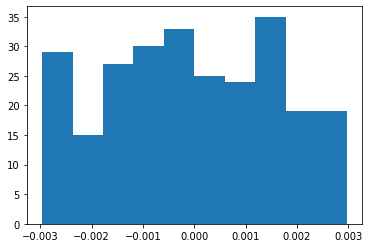

In [46]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, fc_units=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))
    
actor = Actor(state_size, action_size)
plt.hist(list(actor.fc2.parameters())[0][0].detach().numpy())

(array([4., 1., 0., 1., 1., 3., 2., 3., 5., 4.]),
 array([-0.18913655, -0.15147357, -0.11381058, -0.07614759, -0.0384846 ,
        -0.00082161,  0.03684137,  0.07450436,  0.11216735,  0.14983034,
         0.18749332], dtype=float32),
 <a list of 10 Patch objects>)

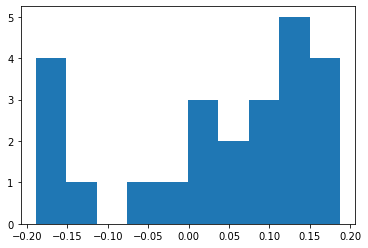

In [27]:
class Actor2(nn.Module):
    def __init__(self, state_size, action_size, fc_units=256):
        super(Actor2, self).__init__()
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2(x))
    
actor = Actor2(state_size, action_size)
plt.hist(list(actor.fc1.parameters())[0][0].detach().numpy())

In [103]:
def weights_init_uniform_rule(layer):
    classname = layer.__class__.__name__
    if classname.find('Linear') != -1:
        y = 1.0/np.sqrt(layer.in_features)
        layer.weight.data.uniform_(-y, y)
        layer.bias.data.fill_(0.0)

In [107]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 64):
        super(QNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, action_size)
        )
        self.reset_parameters()
        
    def reset_parameters(self):
        self.main.apply(weights_init_uniform_rule)

    def forward(self, state):
        x = self.main(state)
        return x
    
model = QNetwork( state_size, action_size)


In [118]:
list(model.main.parameters())[6]

IndexError: list index out of range

(array([3., 2., 4., 1., 1., 2., 3., 1., 5., 2.]),
 array([-0.20317541, -0.16451985, -0.12586427, -0.0872087 , -0.04855314,
        -0.00989757,  0.028758  ,  0.06741357,  0.10606914,  0.14472471,
         0.18338028], dtype=float32),
 <a list of 10 Patch objects>)

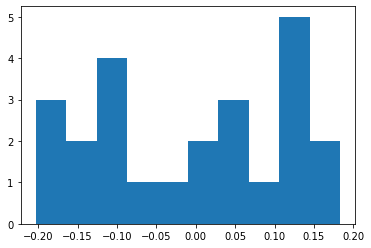

In [123]:
plt.hist(list(model.parameters())[0][0].detach().numpy())

In [105]:
list(model.main.children())

[Linear(in_features=24, out_features=64, bias=True),
 ReLU(inplace=True),
 Linear(in_features=64, out_features=64, bias=True),
 ReLU(inplace=True),
 Linear(in_features=64, out_features=4, bias=True)]

(array([5., 8., 9., 5., 5., 5., 5., 8., 8., 6.]),
 array([-0.20373762, -0.16316546, -0.12259333, -0.08202118, -0.04144903,
        -0.00087689,  0.03969526,  0.0802674 ,  0.12083955,  0.16141169,
         0.20198384], dtype=float32),
 <a list of 10 Patch objects>)

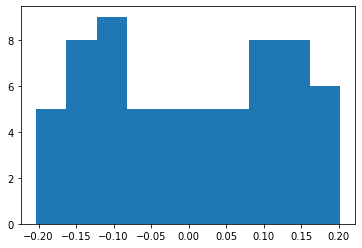

In [89]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size = 64):
        super(QNetwork, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace = True),
            nn.Linear(hidden_size, action_size)
        )
        #self.reset_parameters()
        
    def reset_parameters(self):
        self.main.apply(weights_init_uniform_rule)

    def forward(self, state):
        x = self.main(state)
        return x
    
model = QNetwork( state_size, action_size)
plt.hist(list(model.parameters())[1].detach().numpy())